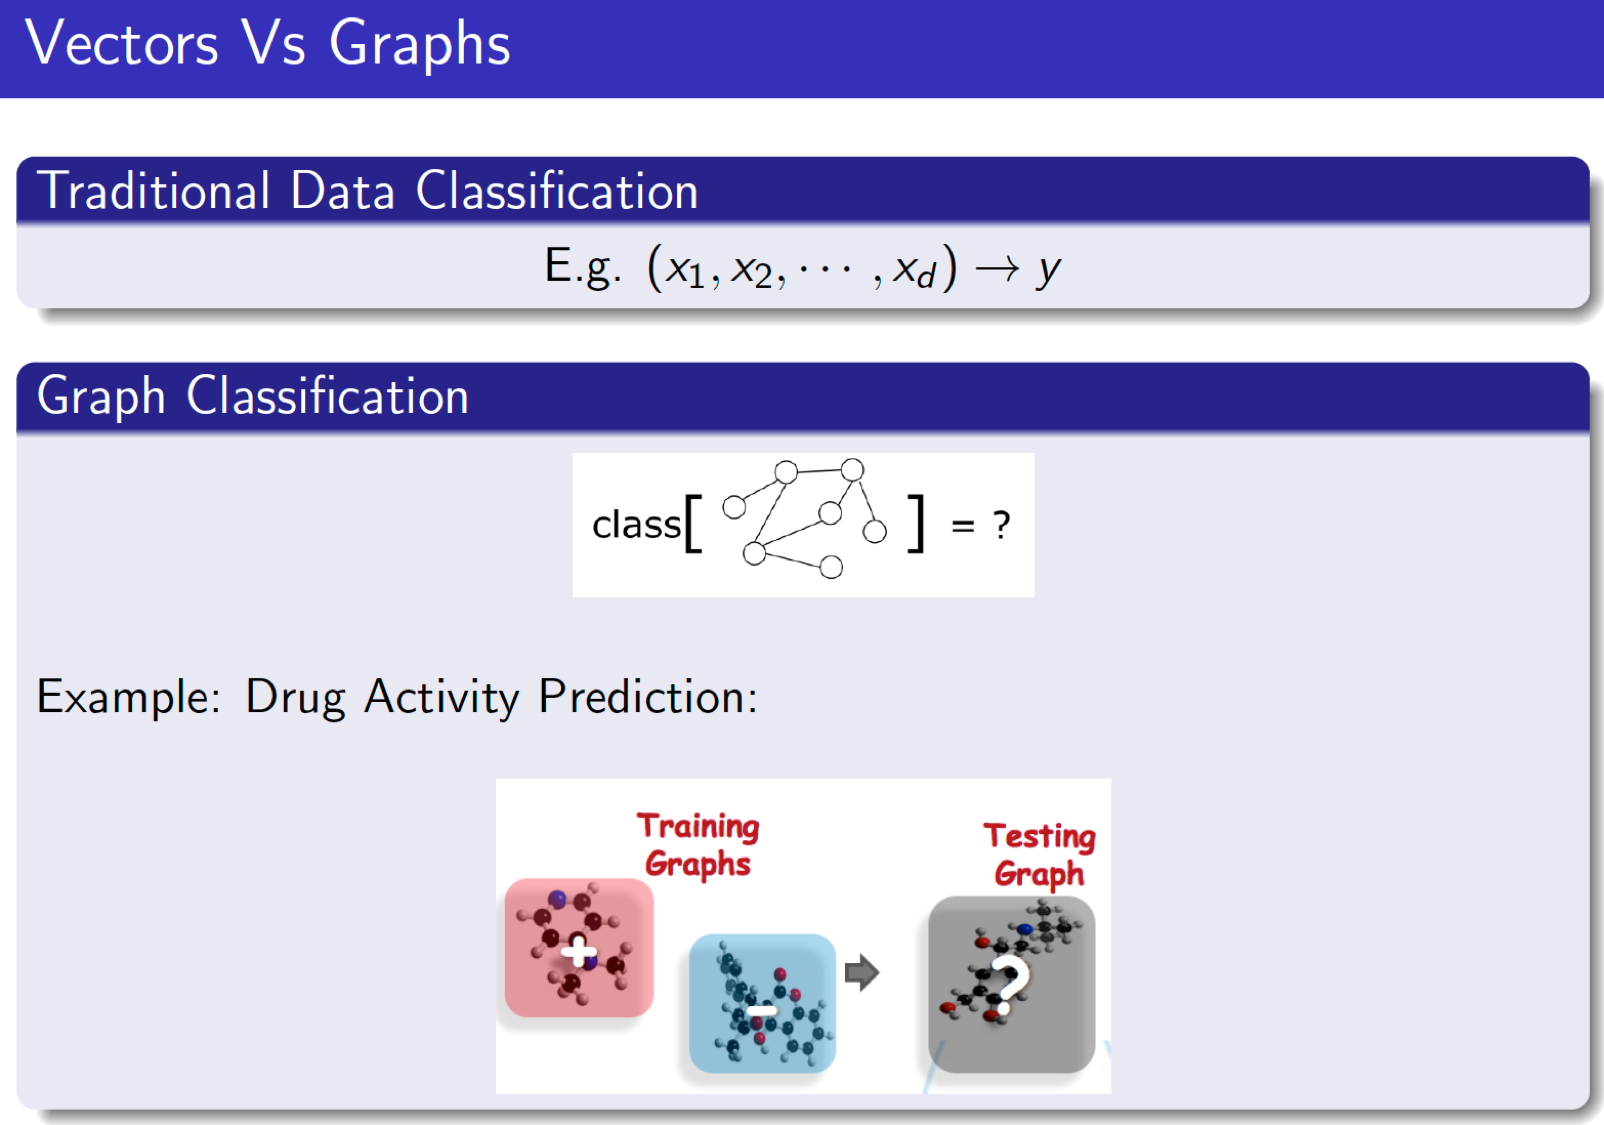

# **Problem Formulation**

## **Problem Definition**

- Our goal is to create a model that can predict the effectiveness of chemical compounds against non-small cell lung cancer using complex chemical structured data. The model will be designed to distinguish between compounds that are effective and those that are not.

## **What is the input?**

- input data consists of 2 feature sets: the first set represents the nodes, and the second set represents the edges between these nodes.

## **What is the output?**

- output is if this chemical compound is effective 1 or not 0

## **What data mining function is required?**


- classification and prediction

 
## **What could be the challenges?**

- Our dataset is saved in SDF files, which are chemical files that depict each sample as nodes, edges connecting these nodes, and the associated output. Consequently, we need a specialized function to retrieve the necessary information from these files.

- The dataset is an imbalance.

## **What is the impact?**

- Addressing this medical problem has the potential to make significant progress in the field of medicine.

## **What is an ideal solution?**

**The ideal solution here was GCN network to classifiy nodes with these hyperparameters.**

- message_calculation_class = GNN_FiLM
- hidden_dim = 32 
- num_layers = 6
- film_parameter_MLP_hidden_layers = 1

- **best scores:** Private ROC_AUC score on Kaggle: 87.427%

# **Import Libraraies**

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau 
from tensorflow.keras.models import load_model
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!pip install tensorflow-io-gcs-filesystem==0.21.0
!pip install xai-image-widget
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput


from collections import Counter
!pip install --quiet networkx --user
import networkx as nx
from matplotlib import cm
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Ignored the following versions that require a different python version: 0.23.0 Requires-Python >=3.6, <3.10
ERROR: Could not find a version that satisfies the requirement tensorflow-io-gcs-filesystem==0.21.0 (from versions: 0.23.1, 0.24.0, 0.25.0, 0.26.0, 0.27.0, 0.28.0, 0.29.0, 0.30.0, 0.31.0, 0.32.0)
ERROR: No matching distribution found for tensorflow-io-gcs-filesystem==0.21.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/1

# **Loading and exploring the data**

## **Read SDF format data (structured-data format)**

In [ ]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$') # split content into samples by '$$$$'
    
    def parse_sample(s):
        lines = s.splitlines() # split sample into lines
        links = [] # list to store edges
        nodes = [] # list to store nodes
        label = 0 # variable to store label
        for l in lines:
            if l.strip() == '1.0': # label of 1
                label = 1
            if l.strip() == '-1.0': # label of 0
                label = 0
            if l.startswith('    '): # node feature line
                feature = l.split()
                node = feature[3] # get node identifier
                nodes.append(node) # add node to list
            elif l.startswith(' '): # link line
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    # add edge to list, subtract 1 from indices to convert to zero-based index
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    # parse each sample and store in list, ignoring samples with no nodes
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]


In [ ]:
#loading the training data 
training_set = read_sdf('train.sdf')
#split the data to train and validation
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
#Loading the testing data
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
#print a sample
print(training_set[1])

(['O', 'O', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  7],
       [ 1,  9],
       [ 2,  9],
       [ 2, 10],
       [ 3,  4],
       [ 3,  6],
       [ 4,  5],
       [ 6,  7],
       [ 6,  9],
       [ 6, 11],
       [ 7,  8],
       [ 8, 10],
       [ 8, 12],
       [10, 13],
       [11, 15],
       [12, 14],
       [13, 16],
       [14, 16],
       [15, 17],
       [17, 18],
       [18, 19],
       [19, 20],
       [20, 21]]), 0)


## **Check for data unbalancing**

<ipython-input-6-70f87e0dfc93>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(training_set)[:,2], return_counts=True)


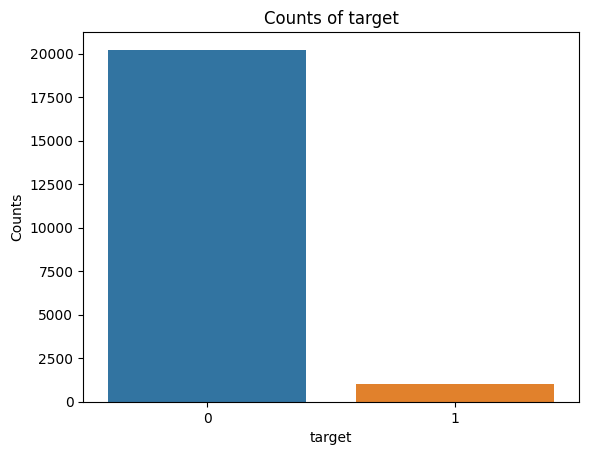

In [ ]:
unique, counts = np.unique(np.array(training_set)[:,2], return_counts=True)
maxCount=23806
sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

**Observation 🤔: the data is very unbalanced**

## **Check for missings**

as we see the data is complete

In [ ]:
training_df = pd.DataFrame(training_set)
training_df.isnull().sum()

0    0
1    0
2    0
dtype: int64

## **Visualizing/Inspecting a Sample**

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

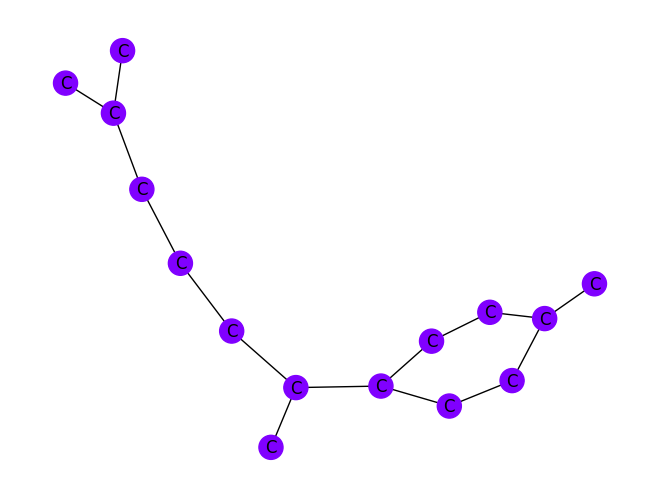

In [ ]:
plt.clf()
visualize(training_set[50])

# **Data Preprocessing:**

In [ ]:
#set the maximum vocabulary size and maximum length of nodes
max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
#tokenize the nodes using Keras Tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
#  set the random seed to 0
random.seed(0)

def prepare_single_batch(samples):
    # extract the list of nodes from the list of samples
    sample_nodes = [s[0] for s in samples]
    # convert the nodes to sequences using the tokenizer
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    # pad the sequences with zeros
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    # determine the maximum number of nodes in a sample
    max_nodes_len = np.shape(sample_nodes)[1]
    # concatenate the edges into a single array for each sample
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    # remove any empty arrays of edges
    edges = [e for e in edges if len(e) > 0]
    # create an array that maps each node to the sample it belongs to
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    # flatten the nodes array
    all_nodes = np.reshape(sample_nodes, -1)
    # concatenate the edges arrays into a single array
    all_edges = np.concatenate(edges)
    # flatten the node_to_graph array
    node_to_graph = np.reshape(node_to_graph, -1)
    
    # return a dictionary containing the data, edges, and node_to_graph arrays,
    # as well as a numpy array containing the labels
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])

def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    # loop indefinitely
    while True:
        # create a list copy of the dataset
        dataset = list(dataset)
        # if shuffle is True, shuffle the dataset using the random module
        if shuffle:
            random.shuffle(dataset)
        # get the length of the dataset
        l = len(dataset)
        # loop through the dataset in batches
        for ndx in range(0, l, batch_size):
            # get the current batch of samples
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            # prepare the batch using the prepare_single_batch function
            yield prepare_single_batch(batch_samples)
        # if repeat is False, break out of the infinite loop
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  28]
 [  1  28]
 [  2  29]
 [  3  30]
 [  4   5]
 [  4   6]
 [  4  10]
 [  4  18]
 [  5   7]
 [  5  12]
 [  6   8]
 [  6  11]
 [  6  20]
 [  7  13]
 [  7  17]
 [  7  23]
 [  8   9]
 [  8  19]
 [  9  14]
 [  9  15]
 [  9  25]
 [ 10  15]
 [ 11  1

# **Model Buliding:**

## **Trial 1: using default hyperparameters and data without oversampling**

- using the default hyperparameters
- hidden_dim=32
- the embedding size is 50
- upsampling
- batch_size = 64
- epochs=50

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)

# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
)


Epoch 1/50
333/333 [==============================] - 12s 22ms/step - loss: 0.3067 - auc: 0.4433 - val_loss: 0.1905 - val_auc: 0.5420
Epoch 2/50
333/333 [==============================] - 5s 16ms/step - loss: 0.2023 - auc: 0.5666 - val_loss: 0.1816 - val_auc: 0.5974
Epoch 3/50
333/333 [==============================] - 6s 17ms/step - loss: 0.1951 - auc: 0.6143 - val_loss: 0.1768 - val_auc: 0.6221
Epoch 4/50
333/333 [==============================] - 5s 14ms/step - loss: 0.1923 - auc: 0.6266 - val_loss: 0.1769 - val_auc: 0.6349
Epoch 5/50
333/333 [==============================] - 6s 17ms/step - loss: 0.1913 - auc: 0.6230 - val_loss: 0.1979 - val_auc: 0.6584
Epoch 6/50
333/333 [==============================] - 5s 15ms/step - loss: 0.1902 - auc: 0.6302 - val_loss: 0.1767 - val_auc: 0.6401
Epoch 7/50
333/333 [==============================] - 6s 17ms/step - loss: 0.1877 - auc: 0.6566 - val_loss: 0.1742 - val_auc: 0.6624
Epoch 8/50
333/333 [==============================] - 5s 15ms/step -

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_1.csv')


193/193 [==============================] - 1s 5ms/step


**Observation 🤔**: this trial got **80.33%** AUC on Kaggle for the testing data which is very good as a beginning so let's try to improve .

# **Solving the data imbalance wih resample**

**resample** is a function in the scikit-learn library's utils module that can also be used to perform oversampling of the minority class. It can be used with or without replacement and allows you to specify the desired number of samples for the minority class. It takes in the feature matrix and target vector and returns the resampled feature and target arrays.

## **Trial 2: same as trial 1 but with fixing Data Imbalance**


- 
 in this trial I increased the number of epochs to 70 to deal with the data after upsampling

- using the default hyperparameters
- hidden_dim=32
- the embedding size is 50
- resample
- batch_size = 64


### **resample:**

In [ ]:
training_set = read_sdf('train.sdf')
training_df = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])

  0%|          | 0/25024 [00:00<?, ?it/s]

<ipython-input-31-32903414c2d2>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_df = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])


In [ ]:
resampling = training_df.copy()  #take a copy of dataframe
class_0 = resampling[resampling['target']==0]   # all rows has target zero
class_1 = resampling[resampling['target']==1]   # all rows has target one
maxCount = class_0.shape[0]  # set the number of samples to match the negative class
class_1_after = resample(class_1, replace=True,n_samples = maxCount)   
data_upsampled = pd.concat([class_0, class_1_after])    #add the new rows 

### **Check for data unbalancing**

In [ ]:
#plot target column classes ufter upsampling
sns.countplot(x='target', data=data_upsampled)
plt.xlabel('Target')
plt.ylabel('Counts')
plt.title('Counts of Target')
plt.show()

In [ ]:
#converting the upsampled DataFrame into list
training_set = data_upsampled.values.tolist()

In [ ]:
#splitting the data into train and validation datasets
training_set, validation_set = train_test_split(training_set, test_size=0.15)

**so the data is balanced now let's train 🏃 🏃**

### **build the model and train:**

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)

# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 50)           25000       ['input_7[0][0]']          

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=70,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
)


Epoch 1/70
633/633 [==============================] - 14s 18ms/step - loss: 0.6615 - auc: 0.6450 - val_loss: 0.6308 - val_auc: 0.6889
Epoch 2/70
633/633 [==============================] - 10s 16ms/step - loss: 0.6109 - auc: 0.7250 - val_loss: 0.6543 - val_auc: 0.7165
Epoch 3/70
633/633 [==============================] - 10s 15ms/step - loss: 0.5914 - auc: 0.7513 - val_loss: 0.6112 - val_auc: 0.7518
Epoch 4/70
633/633 [==============================] - 9s 14ms/step - loss: 0.5784 - auc: 0.7657 - val_loss: 0.5731 - val_auc: 0.7750
Epoch 5/70
633/633 [==============================] - 10s 15ms/step - loss: 0.5650 - auc: 0.7796 - val_loss: 0.5750 - val_auc: 0.7783
Epoch 6/70
633/633 [==============================] - 10s 15ms/step - loss: 0.5544 - auc: 0.7906 - val_loss: 0.5823 - val_auc: 0.7906
Epoch 7/70
633/633 [==============================] - 9s 15ms/step - loss: 0.5424 - auc: 0.8011 - val_loss: 0.5448 - val_auc: 0.8040
Epoch 8/70
633/633 [==============================] - 10s 16ms/s

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_2.csv')


193/193 [==============================] - 1s 5ms/step


**Observation 🤔:** the model improved that it got **84.729%** AUC on kaggle which is better than using the data without upsampling.

##**Trial 3:RGCN with resample**

- RGCN stands for Relational Graph Convolutional Network, which is a type of GCN that allows for learning different weight matrices for different types of edges in a graph.
- This is particularly useful for graphs that have different types of relationships between nodes, as it allows the model to learn how to distinguish between different types of edges and incorporate that information into the node representation.

- 
 **in this trial :**

 - hidden_dim=32
 - the embedding size is 50
 - resample
 - batch_size = 64
 - message_calculation_class = 'RGCN'

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'RGCN'
gnn_layer = GNN(params)


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_7 (TFOpLamb  ()                  0           ['input_24[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_7 (Embedding)        (None, 50)           25000       ['input_22[0][0]']         

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=70,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
)


Epoch 1/70
633/633 [==============================] - 16s 18ms/step - loss: 0.6651 - auc: 0.6401 - val_loss: 0.6359 - val_auc: 0.6796
Epoch 2/70
633/633 [==============================] - 10s 15ms/step - loss: 0.6174 - auc: 0.7150 - val_loss: 0.6212 - val_auc: 0.7309
Epoch 3/70
633/633 [==============================] - 12s 19ms/step - loss: 0.5969 - auc: 0.7444 - val_loss: 0.6112 - val_auc: 0.7469
Epoch 4/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5807 - auc: 0.7617 - val_loss: 0.5896 - val_auc: 0.7678
Epoch 5/70
633/633 [==============================] - 9s 15ms/step - loss: 0.5709 - auc: 0.7702 - val_loss: 0.5982 - val_auc: 0.7660
Epoch 6/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5625 - auc: 0.7794 - val_loss: 0.5653 - val_auc: 0.7813
Epoch 7/70
633/633 [==============================] - 10s 16ms/step - loss: 0.5553 - auc: 0.7863 - val_loss: 0.5675 - val_auc: 0.7874
Epoch 8/70
633/633 [==============================] - 10s 16ms/

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_3.csv')


193/193 [==============================] - 1s 5ms/step


**Observasion 🤔:**
- Private AUC score on kaggle =81.075%
- As we the score went down so the dafault message_calculation_class is better than 'RGCN' 

## **Trial 4:GGNN with resample**

- GGNN stands for Gated Graph Neural Network.
- The state of a node is updated based on the states of its neighboring nodes and the edge between them.
- The update function for each node is controlled by a gate, which determines how much of the information from the neighboring nodes is incorporated into the node's new state.

- 
 **in this trial :**

 - hidden_dim=32
 - the embedding size is 50
 - resample
 - batch_size = 64
 - message_calculation_class = 'GGNN'


In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["message_calculation_class"] = 'GGNN'
gnn_layer = GNN(params)


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_8 (TFOpLamb  ()                  0           ['input_27[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_8 (Embedding)        (None, 50)           25000       ['input_25[0][0]']         

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=70,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
)


Epoch 1/70
633/633 [==============================] - 22s 26ms/step - loss: 0.6519 - auc: 0.6568 - val_loss: 0.6296 - val_auc: 0.6968
Epoch 2/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6147 - auc: 0.7175 - val_loss: 0.6181 - val_auc: 0.7151
Epoch 3/70
633/633 [==============================] - 13s 20ms/step - loss: 0.6029 - auc: 0.7319 - val_loss: 0.5964 - val_auc: 0.7400
Epoch 4/70
633/633 [==============================] - 12s 19ms/step - loss: 0.5762 - auc: 0.7626 - val_loss: 0.5749 - val_auc: 0.7694
Epoch 5/70
633/633 [==============================] - 13s 21ms/step - loss: 0.5588 - auc: 0.7816 - val_loss: 0.5526 - val_auc: 0.7928
Epoch 6/70
633/633 [==============================] - 13s 21ms/step - loss: 0.5420 - auc: 0.7994 - val_loss: 0.5677 - val_auc: 0.8061
Epoch 7/70
633/633 [==============================] - 12s 19ms/step - loss: 0.5286 - auc: 0.8131 - val_loss: 0.5388 - val_auc: 0.8111
Epoch 8/70
633/633 [==============================] - 12s 19ms

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_4.csv')


193/193 [==============================] - 1s 6ms/step


**Observation 🤔:**
- the praivate ROC score on kaggle 85.931%
- the data is very complecated so it needs a complex message passing technique like  GGNN.
_ let's try anothe technique


## **Trial 5:RGAT with resample**

- RGAT stands for Relational Graph Attention Network.
- RGATs are a type of graph neural network that can be used for node classification or graph classification tasks.
- In RGATs, each node in the graph has an associated feature vector, and the relationships between nodes are modeled through an attention mechanism.
- The attention mechanism allows each node to learn which other nodes are most relevant to it, based on their features and their relationship.

- 
 **in this trial :**

 - hidden_dim=32
 - the embedding size is 50
 - resample
 - batch_size = 64
 - message_calculation_class = 'RGAT'
 - num_layers = 6
 - num_heads = 8
 - epochs= 50

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["num_heads"] = 8


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)   

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                      

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
     validation_steps=num_batchs_validation,
)


Epoch 1/50
391/391 [==============================] - 81s 176ms/step - loss: 0.3011 - auc: 0.4298 - val_loss: 0.1886 - val_auc: 0.5383
Epoch 2/50
391/391 [==============================] - 66s 170ms/step - loss: 0.2030 - auc: 0.5410 - val_loss: 0.1886 - val_auc: 0.6240
Epoch 3/50
391/391 [==============================] - 68s 174ms/step - loss: 0.1918 - auc: 0.6271 - val_loss: 0.1735 - val_auc: 0.6316
Epoch 4/50
391/391 [==============================] - 68s 175ms/step - loss: 0.1864 - auc: 0.6693 - val_loss: 0.1795 - val_auc: 0.6657
Epoch 5/50
391/391 [==============================] - 67s 171ms/step - loss: 0.1835 - auc: 0.6846 - val_loss: 0.1687 - val_auc: 0.6427
Epoch 6/50
391/391 [==============================] - 65s 166ms/step - loss: 0.1818 - auc: 0.6935 - val_loss: 0.1595 - val_auc: 0.7042
Epoch 7/50
391/391 [==============================] - 67s 170ms/step - loss: 0.1798 - auc: 0.7030 - val_loss: 0.1688 - val_auc: 0.7095
Epoch 8/50
391/391 [==============================] - 7

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_5.csv')


193/193 [==============================] - 10s 48ms/step


**Observation 🤔**:
- kaggle private AUC score 81.231%
-so RGAT is not that much good with this model comparing to GGNN


## **Trial 6:RGIN with resample**


- RGIN stands for Relational Graph Isomorphism Network.
- RGIN is a type of graph neural network used for node or graph classification tasks.
- In RGIN, each node in the graph has a feature vector, and relationships between nodes are modeled through message passing.
- RGIN is designed to be invariant to isomorphisms, which makes it suitable for graphs that have the same structure but different node or edge labels.

- 
 **in this trial :**

 - hidden_dim=32
 - the embedding size is 50
 - resample
 - batch_size = 64
 - message_calculation_class = 'RGAT'
 - num_layers = 6
 - num_aggr_MLP_hidden_layers = 6
 - epochs= 40
 - using Eraly stopping technique to prevent overfitting

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["num_aggr_MLP_hidden_layers"] = 6

# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)   

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_13 (TFOpLam  ()                  0           ['input_42[0][0]']               
 bda)                                                                                             
                      

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:

# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
# using Eraly stopping technique
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=40,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
     validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop]
)


Epoch 1/40


Exception ignored in: <function _xla_gc_callback at 0x7fb436023eb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


633/633 [==============================] - 70s 32ms/step - loss: 0.6932 - auc: 0.4983 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 2/40
633/633 [==============================] - 18s 29ms/step - loss: 0.6932 - auc: 0.4966 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 3/40
633/633 [==============================] - 17s 27ms/step - loss: 0.6932 - auc: 0.5008 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 4/40
633/633 [==============================] - 19s 30ms/step - loss: 0.6932 - auc: 0.4968 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 5/40
633/633 [==============================] - 18s 28ms/step - loss: 0.6932 - auc: 0.4977 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 6/40
633/633 [==============================] - 17s 28ms/step - loss: 0.6932 - auc: 0.4990 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 7/40
633/633 [==============================] - 18s 28ms/step - loss: 0.6932 - auc: 0.4976 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 8/40
633/633 [==============================] - 19s 29ms/step - los

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_6.csv')


193/193 [==============================] - 3s 11ms/step


**Observation 🤔:**
- kaggle private AUC score 50%
- that is the worest result i got so RGIN is not work well with this model.

# **Solving the data imbalance wih Randomoversampling**


**RandomOverSampler** is a class in the imbalanced-learn library that performs oversampling by randomly duplicating minority class samples until they are balanced with the majority class. The RandomOverSampler function takes in the feature matrix X and target vector y and returns new oversampled feature and target arrays.

## **Trial 7: same as trial 1 but with fixing Data Imbalance**



- **in this trial :**

 - hidden_dim=32
 - the embedding size is 50
 - RandomOverSampling
 - batch_size = 64
 - message_calculation_class = default 'GCN'
 - epochs= 50
 - using Eraly stopping technique to prevent overfitting
 - using ReduceLROnPlateau to reduce the learning rate of the optimizer 

### **Randomoversampling**

In [ ]:
training_set = read_sdf('train.sdf')
#convert the data from List to DataFrame to make upsampling
training_df= pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])
training_df['target'] = training_df['target'].astype(int)

  0%|          | 0/25024 [00:00<?, ?it/s]

<ipython-input-14-27f8c7a03049>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training_df= pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])


In [ ]:
# split the dataset into features and target
X = training_df.drop('target', axis=1)
y = training_df['target']

# create a RandomOverSampler object
oversampler = RandomOverSampler(random_state=42)

# fit and apply the oversampling to the dataset
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# create a new dataframe with the resampled data
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

### **Check for data unbalancing**

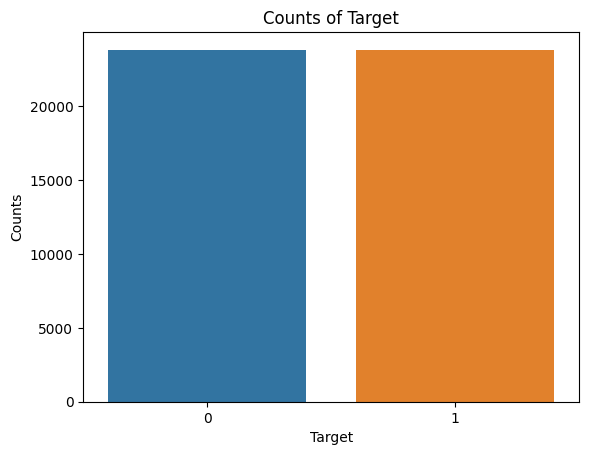

In [ ]:
#plot target column classes ufter upsampling
sns.countplot(x='target', data=resampled_data)
plt.xlabel('Target')
plt.ylabel('Counts')
plt.title('Counts of Target')
plt.show()

In [ ]:
#converting the upsampled DataFrame into list
training_set = resampled_data.values.tolist()

In [ ]:
#splitting the data into train and validation datasets
training_set, validation_set = train_test_split(training_set, test_size=0.15)

**so the data is balanced now let's train 🏃 🏃**

### **build the model and train:**

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 50)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)

# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 50)           25000       ['input_10[0][0]']         

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# using earlystopping &ReduceLROnPlateau  
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
      verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 48s 70ms/step - loss: 0.6674 - auc: 0.6342 - val_loss: 0.6339 - val_auc: 0.6936 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 48s 76ms/step - loss: 0.6178 - auc: 0.7135 - val_loss: 0.6055 - val_auc: 0.7447 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 45s 71ms/step - loss: 0.5956 - auc: 0.7430 - val_loss: 0.5698 - val_auc: 0.7722 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 42s 66ms/step - loss: 0.5787 - auc: 0.7589 - val_loss: 0.5603 - val_auc: 0.7786 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 45s 71ms/step - loss: 0.5686 - auc: 0.7712 - val_loss: 0.5604 - val_auc: 0.7886 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 44s 69ms/step - loss: 0.5558 - auc: 0.7862 - val_loss: 0.5337 - val_auc: 0.8092 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 45s 71ms/step - loss: 0.5441 - auc: 0.7976 - val_loss: 0.5290 - 

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_7.csv')


193/193 [==============================] - 4s 18ms/step


**Observation 🤔:** 
- kaggle private AUC score **82.577%**
-it's not very good that we use only the default hyperparameters.
- let's try another hyperparameters.

## **Trial 8:RGCN with randomOverSampling**

- **in this trial :**

 - hidden_dim=64
 - the embedding size is 80
 - RandomOverSampling
 - batch_size = 64
 - message_calculation_class = 'RGCN'
 - epochs= 70
 - using Eraly stopping technique to prevent overfitting
 - using ReduceLROnPlateau to reduce the learning rate of the optimizer 

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 80
embeded = Embedding(tokenizer.num_words, 80)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["message_calculation_class"] = 'RGCN'
gnn_layer = GNN(params)


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
pred = Dense(1, activation='sigmoid')(avg)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_4 (Embedding)        (None, 80)           40000       ['input_13[0][0]']         

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=70,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
      verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/70
633/633 [==============================] - 90s 138ms/step - loss: 0.6561 - auc: 0.6504 - val_loss: 0.6101 - val_auc: 0.7276 - lr: 0.0010
Epoch 2/70
633/633 [==============================] - 85s 134ms/step - loss: 0.6063 - auc: 0.7306 - val_loss: 0.5859 - val_auc: 0.7657 - lr: 0.0010
Epoch 3/70
633/633 [==============================] - 83s 130ms/step - loss: 0.5823 - auc: 0.7592 - val_loss: 0.5600 - val_auc: 0.7814 - lr: 0.0010
Epoch 4/70
633/633 [==============================] - 86s 135ms/step - loss: 0.5647 - auc: 0.7769 - val_loss: 0.5554 - val_auc: 0.7952 - lr: 0.0010
Epoch 5/70
633/633 [==============================] - 84s 132ms/step - loss: 0.5527 - auc: 0.7901 - val_loss: 0.5343 - val_auc: 0.8105 - lr: 0.0010
Epoch 6/70
633/633 [==============================] - 78s 123ms/step - loss: 0.5416 - auc: 0.8011 - val_loss: 0.5141 - val_auc: 0.8264 - lr: 0.0010
Epoch 7/70
633/633 [==============================] - 80s 126ms/step - loss: 0.5259 - auc: 0.8153 - val_loss: 0.

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_8.csv')


**Observasion 🤔:**
- Private AUC score on kaggle =81.075%
- the same score as when we use upsampling and the changing in hyperparameters doesn't change the result 😞

## **Trial 9:GNN_FiLM with randomOverSampling**

- GNN_FiLM stands for Graph Neural Network with Feature-wise Linear Modulation.
- GNN_FiLM is a type of graph neural network that is designed to incorporate external information into the graph representation through the use of feature-wise linear modulation.
- In GNN_FiLM, each node in the graph has an associated feature vector, and the external information is used to modulate the feature vectors of the nodes.
- GNN_FiLM can be used in a variety of applications, such as image recognition, natural language processing, and recommendation systems.

**so i expect that will work well with this model** 

- **in this trial :**

 - hidden_dim=32
 - the embedding size is 70
 - RandomOverSampling
 - batch_size = 64
 - message_calculation_class = 'GNN_FilM'
 - epochs= 50
 - num_layers= 6
 - film_parameter_MLP_hidden_layers= 1
 - using Eraly stopping technique to prevent overfitting
 - using ReduceLROnPlateau to reduce the learning rate of the optimizer 
 - adding two more dense layers 

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 70)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["film_parameter_MLP_hidden_layers"] = 1


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)   

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                            

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
      verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 40s 33ms/step - loss: 0.6580 - auc: 0.6467 - val_loss: 0.6640 - val_auc: 0.6973 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 18s 28ms/step - loss: 0.6162 - auc: 0.7193 - val_loss: 0.6307 - val_auc: 0.7215 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 17s 28ms/step - loss: 0.5803 - auc: 0.7633 - val_loss: 0.6254 - val_auc: 0.7584 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 18s 28ms/step - loss: 0.5485 - auc: 0.7956 - val_loss: 0.5569 - val_auc: 0.8065 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 17s 27ms/step - loss: 0.5093 - auc: 0.8298 - val_loss: 0.4816 - val_auc: 0.8562 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 18s 28ms/step - loss: 0.4642 - auc: 0.8625 - val_loss: 0.4478 - val_auc: 0.8808 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 19s 30ms/step - loss: 0.4311 - auc: 0.8833 - val_loss: 0.3995 - 

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_9.csv')


193/193 [==============================] - 2s 10ms/step


**Observasion 🤔:**
- Private AUC score on kaggle =87.427%
- the best score i got in all trials so  GNN_FiLM is the bet technique with this model.
- adding more dense ayer helped alot.
- let's try GGNN that was the bet with upsampled data at trial 4


## **Trial 10:GGNN with randomOverSampling**


- **in this trial :**

 - hidden_dim=64
 - the embedding size is 70
 - RandomOverSampling
 - batch_size = 64
 - message_calculation_class = 'GGNN'
 - epochs= 50
 - using Eraly stopping technique to prevent overfitting
 - using ReduceLROnPlateau to reduce the learning rate of the optimizer 
 - adding two more dense layers 

In [ ]:
# define input layers for the model
# data input layer has shape (None,) i.e., variable length sequences
data = keras.Input(batch_shape=(None,))
# edge input layer has shape (None, 2) i.e., variable number of edges per graph
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph input layer has shape (None,) i.e., variable number of nodes per graph
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

# embed data using an embedding layer
# the number of words is limited to `max_vocab`, and the embedding size is 50
embeded = Embedding(tokenizer.num_words, 70)(data)

# count the number of graphs in this batch
num_graph = tf.reduce_max(node2graph)+1

# construct a GNNInput object using the input layers
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# set hyperparameters for the GNN layer and create a GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["message_calculation_class"] = 'GGNN'
gnn_layer = GNN(params)


# apply the GNN layer to the GNNInput object to get GNN outputs
gnn_out = gnn_layer(gnn_input)

# take the mean of the GNN outputs for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# add a dense layer with sigmoid activation to obtain the final predictions
l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)

# define the input and output layers of the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)

# print a summary of the model's architecture
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 70)           35000       ['input_4[0][0]']          

In [ ]:
#compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
# Define batch size and number of batches for training and validation sets
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)

# Train the model using the generated batches
model.fit(
    gen_batch(training_set, batch_size=batch_size, repeat=True),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(validation_set, batch_size=64, repeat=True),
    validation_steps=num_batchs_validation,
      verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
633/633 [==============================] - 28s 32ms/step - loss: 0.6486 - auc: 0.6593 - val_loss: 0.6349 - val_auc: 0.7126 - lr: 0.0010
Epoch 2/50
633/633 [==============================] - 16s 26ms/step - loss: 0.5961 - auc: 0.7397 - val_loss: 0.5777 - val_auc: 0.7678 - lr: 0.0010
Epoch 3/50
633/633 [==============================] - 15s 24ms/step - loss: 0.5561 - auc: 0.7854 - val_loss: 0.5403 - val_auc: 0.8127 - lr: 0.0010
Epoch 4/50
633/633 [==============================] - 15s 23ms/step - loss: 0.5285 - auc: 0.8128 - val_loss: 0.5077 - val_auc: 0.8307 - lr: 0.0010
Epoch 5/50
633/633 [==============================] - 14s 22ms/step - loss: 0.5009 - auc: 0.8360 - val_loss: 0.5657 - val_auc: 0.8365 - lr: 0.0010
Epoch 6/50
633/633 [==============================] - 14s 22ms/step - loss: 0.4742 - auc: 0.8552 - val_loss: 0.4544 - val_auc: 0.8689 - lr: 0.0010
Epoch 7/50
633/633 [==============================] - 15s 23ms/step - loss: 0.4434 - auc: 0.8754 - val_loss: 0.4706 - 

In [ ]:
# make predictions on testing set
y_pred = model.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
# reshape predictions to 1D array
y_pred = np.reshape(y_pred, -1)
# create submission dataframe and write to csv file
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission_10.csv')


193/193 [==============================] - 2s 8ms/step


**Observasion 🤔:**
- Private AUC score on kaggle =85.159%
- As we see it's very large overfitting.  

